### Duck typing

In [1]:
from hagis import Layer

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/USA/MapServer/0")

for city in layer.query():
    print(city.areaname)


Ewa Beach
Halawa
Hilo
Honolulu
Kahului
Kailua
Kaneohe
Kaneohe Station
Kihei
Makakilo City
Mililani Town
Nanakuli
Pearl City
Schofield Barracks
Wahiawa
Waianae
Wailuku
Waimalu
Waipahu
Waipio
Alabaster
Albertville
Alexander City
Anniston
Athens
Auburn
Bessemer
Birmingham
Center Point
Cullman
Daphne
Decatur
Dothan
Enterprise
Eufaula
Fairfield
Fairhope
Florence
Forestdale
Fort Payne
Gadsden
Gardendale
Hartselle
Helena
Homewood
Hoover
Hueytown
Huntsville
Jasper
Leeds
Madison
Millbrook
Mobile
Montgomery
Mountain Brook
Muscle Shoals
Northport
Opelika
Oxford
Ozark
Pelham
Phenix City
Prattville
Prichard
Saks
Saraland
Scottsboro
Selma
Smiths
Sylacauga
Talladega
Tillmans Corner
Troy
Trussville
Tuscaloosa
Tuskegee
Vestavia Hills
Arkadelphia
Bella Vista
Benton
Bentonville
Blytheville
Cabot
Camden
Conway
El Dorado
Fayetteville
Forrest City
Fort Smith
Harrison
Hope
Hot Springs
Jacksonville
Jonesboro
Little Rock
Magnolia
Maumelle
Mountain Home
North Little Rock
Paragould
Pine Bluff
Rogers
Russellville

### Querying with a type argument

In [2]:
from hagis import Layer, Point

class City:
    objectid: int
    areaname: str
    pop2000: int
    shape: Point

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/USA/MapServer/0", City)

for city in layer.query("pop2000 > 1000000", orderByFields="pop2000 DESC", outSR=102100):
    print(city.areaname, city.pop2000, city.shape.x, city.shape.y)


New York 8008278 -8228506.005934231 4968813.6412190115
Los Angeles 3694820 -13177554.26025346 4040376.9659394654
Chicago 2896016 -9760422.274562363 5137143.132805097
Houston 1953631 -10618006.258402834 3473108.472451801
Philadelphia 1517550 -8365080.101208865 4865653.375238131
Phoenix 1321045 -12476276.642097982 3965648.0787066477
San Diego 1223400 -13040671.36805095 3866078.150301196
Dallas 1188580 -10774298.044017512 3868724.7951710317
San Antonio 1144646 -10966381.597921556 3433242.4394413484


### Mapping to a dataclass

In [3]:
from hagis import Layer, Polyline
from dataclasses import dataclass

@dataclass(frozen=True)
class Highway:
    objectid: int
    route: str
    shape: Polyline

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/USA/MapServer/1", Highway)

for highway in layer.query():
    print(highway.route)


Interstate  82
Interstate (OR/ID/UT)  84
Interstate  94
Interstate  94
Interstate  35
Interstate 494
Interstate  35
Interstate  35
Interstate  90
Interstate  35
Interstate  90
Interstate  29
Interstate  90
Interstate  90
Interstate  89
Interstate  15
Interstate (MA) 495
Interstate 293
Interstate  86
Interstate (OR/ID/UT)  84
Interstate  90
Interstate  93
Interstate 390
Interstate  96
Interstate  90
Interstate  95
Interstate  69
Interstate  90
Interstate (MA) 495
Interstate  95
Interstate  90
Interstate  90
Interstate (NY)  88
Interstate  81
Interstate  90
Interstate (MA) 495
Interstate 294
Interstate  90
Interstate 294
Interstate  90
Interstate  90
Interstate 294
Interstate (IL)  88
Interstate 294
Interstate (IL)  88
Interstate  95
Interstate  55
Interstate 294
Interstate  91
Interstate (IL)  88
Interstate (PA/NY/CT)  84
Interstate 380
Interstate  15
Interstate (OR/ID/UT)  84
Interstate  80
Interstate  35
Interstate 294
Interstate  35
Interstate  57
Interstate (IL)  88
Interstate  80
I

### Mapping to Esri geometry

California 33871648 (-119.60114711638413, 37.241741100392474)


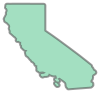

Texas 20851820 (-99.35209636088696, 31.491160348955905)


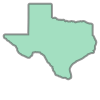

New York 18976457 (-75.51225743376672, 42.94666085682523)


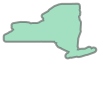

Florida 15982378 (-82.4955741823458, 28.658676471012605)


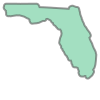

In [4]:
from hagis import Layer
from arcgis.geometry import Polygon

class State:
    state_name: str
    pop2000: int
    shape: Polygon

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/USA/MapServer/2", State)

for state in layer.query(record_count=4, orderByFields="pop2000 DESC"):
    print(state.state_name, state.pop2000, state.shape.centroid)
    display(state.shape.buffer(0.2))


### Custom property to field mapping

In [5]:
from hagis import Layer, Polyline

class Highway:
    objectid: int
    name: str  # This is actually called "route" in the table.
    shape: Polyline

custom_mapping = {
    "name": "route",
    "type": "type" # This is not even defined in the Highway class (i.e. customer-specific field).
}

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/USA/MapServer/1", Highway, **custom_mapping)

for highway in layer.query():
    print(highway.name, getattr(highway, "type")) # Can be accessed like highway.type (though it doesn't make sense to do so).


Interstate  82 Multi-Lane Divided
Interstate (OR/ID/UT)  84 Multi-Lane Divided
Interstate  94 Multi-Lane Divided
Interstate  94 Multi-Lane Divided
Interstate  35 Multi-Lane Divided
Interstate 494 Multi-Lane Divided
Interstate  35 Multi-Lane Divided
Interstate  35 Multi-Lane Divided
Interstate  90 Multi-Lane Divided
Interstate  35 Multi-Lane Divided
Interstate  90 Multi-Lane Divided
Interstate  29 Multi-Lane Divided
Interstate  90 Multi-Lane Divided
Interstate  90 Multi-Lane Divided
Interstate  89 Multi-Lane Divided
Interstate  15 Multi-Lane Divided
Interstate (MA) 495 Multi-Lane Divided
Interstate 293 Multi-Lane Divided
Interstate  86 Multi-Lane Divided
Interstate (OR/ID/UT)  84 Multi-Lane Divided
Interstate  90 Multi-Lane Divided
Interstate  93 Multi-Lane Divided
Interstate 390 Multi-Lane Divided
Interstate  96 Multi-Lane Divided
Interstate  90 Multi-Lane Divided
Interstate  95 Multi-Lane Divided
Interstate  69 Multi-Lane Divided
Interstate  90 Multi-Lane Divided
Interstate (MA) 495 M

### Lazily-evaluated sequence

In [6]:
from hagis import Layer
from datetime import datetime

class Rain:
    objectid: int
    site_no: str
    date_time: datetime
    rainfall_inch: float

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/SpatioTemporalAggregation/RainfallTimeSeriesDataIllinois/MapServer/7", Rain)

print(f"This layer has {layer.count()} records!")

# Keep querying.
for rain in layer.query(record_count=12345):
    print(rain.__dict__)


This layer has 572416 records!
{'objectid': 1, 'site_no': '220739159373001', 'date_time': datetime.datetime(2012, 1, 1, 2, 15), 'rainfall_inch': 0.01}
{'objectid': 2, 'site_no': '200518155405801', 'date_time': datetime.datetime(2012, 1, 1, 2, 30), 'rainfall_inch': 0.01}
{'objectid': 3, 'site_no': '194117155174801', 'date_time': datetime.datetime(2012, 1, 1, 2, 30), 'rainfall_inch': 0.01}
{'objectid': 4, 'site_no': '220927159355001', 'date_time': datetime.datetime(2012, 1, 1, 3, 0), 'rainfall_inch': 0.01}
{'objectid': 5, 'site_no': '200518155405801', 'date_time': datetime.datetime(2012, 1, 1, 3, 15), 'rainfall_inch': 0.01}
{'objectid': 6, 'site_no': '200518155405801', 'date_time': datetime.datetime(2012, 1, 1, 4, 0), 'rainfall_inch': 0.01}
{'objectid': 7, 'site_no': '220523159341201', 'date_time': datetime.datetime(2012, 1, 1, 4, 45), 'rainfall_inch': 0.01}
{'objectid': 8, 'site_no': '213335157540601', 'date_time': datetime.datetime(2012, 1, 1, 5, 0), 'rainfall_inch': 0.03}
{'objectid':

### Insert

In [7]:
from hagis import Layer, Point

class Ambulance:
    objectid: int
    unitname: str
    type: int
    speed: float
    shape: Point

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/RedlandsEmergencyVehicles/FeatureServer/0", Ambulance)

ambulance = Ambulance()
ambulance.unitname = "Created by https://pypi.org/project/hagis/"
ambulance.type = 1
ambulance.speed = 12.34567
ambulance.shape = Point()
ambulance.shape.x, ambulance.shape.y = -120, 50

# Returns the newly created object ids.
oid = layer.insert([ambulance])[0]

layer.find(oid).__dict__


{'objectid': 426633,
 'unitname': 'Created by https://pypi.org/project/hagis/',
 'type': 1,
 'speed': 12.34567,
 'shape': <hagis.Point at 0x1add83a4a90>}

### Update

In [8]:
from hagis import Layer

class Ambulance:
    objectid: int
    unitname: str

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/RedlandsEmergencyVehicles/FeatureServer/0", Ambulance)

where_clause = "unitname LIKE '%hagis%'"

# Update requires materializing records first.
ambulances = list(layer.query(where_clause))

for ambulance in ambulances:
    ambulance.unitname = "Updated by https://pypi.org/project/hagis/"

# Send the list back to the server.
layer.update(ambulances)

for ambulance in layer.query(where_clause):
    print(ambulance.__dict__)


{'objectid': 426624, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426625, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426626, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426627, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426628, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426629, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426630, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426631, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426632, 'unitname': 'Updated by https://pypi.org/project/hagis/'}
{'objectid': 426633, 'unitname': 'Updated by https://pypi.org/project/hagis/'}


### Delete

In [9]:
from hagis import Layer

layer = Layer("https://sampleserver6.arcgisonline.com/arcgis/rest/services/RedlandsEmergencyVehicles/FeatureServer/0")

where_clause = "unitname LIKE '%hagis%'"

print("Before", layer.count(where_clause))

# Delete requires the where clause.
layer.delete(where_clause)

print("After", layer.count(where_clause))


Before 10
After 0


### Generic operations

In [10]:
from dataclasses import dataclass
from datetime import datetime, timedelta
from typing import Iterator, Optional, Type, TypeVar
from hagis import Layer, Point, Polyline, Polygon

URL = "https://sampleserver6.arcgisonline.com/arcgis/rest/services/Wildfire/FeatureServer"

@dataclass(frozen=True)
class Tracked:
    objectid: int
    created_user: str
    created_date: datetime
    last_edited_user: Optional[str]
    last_edited_date: Optional[datetime]

@dataclass(frozen=True)
class ResponsePoint(Tracked):
    rotation: Optional[int]
    description: Optional[str]
    shape: Point

@dataclass(frozen=True)
class ResponseLine(Tracked):
    symbolid: Optional[int]
    timestamp: Optional[datetime]
    description: Optional[str]
    shape__length: float
    shape: Polyline

@dataclass(frozen=True)
class ResponsePolygon(Tracked):
    objectid: int
    symbolid: Optional[int]
    description: Optional[str]
    shape__area: float
    shape: Polygon

T = TypeVar("T", bound=Tracked)

def get_recent_responses(model: Type[T], layer_id: int, hours: int) -> Iterator[T]:
    layer = Layer(f"{URL}/{layer_id}", model)
    time = datetime.utcnow() + timedelta(hours=-hours)
    for response in layer.query(lambda x: x.last_edited_date is not None and x.last_edited_date > time):
        yield response

last_n_hours = 4

print(f"Response points edited in the last {last_n_hours} hour(s)")
for r in get_recent_responses(ResponsePoint, 0, last_n_hours):
    print(r.last_edited_date, r.rotation)

print(f"Response lines edited in the last {last_n_hours} hour(s)")
for r in get_recent_responses(ResponseLine, 1, last_n_hours):
    print(r.last_edited_date, r.timestamp)

print(f"Response polygons edited in the last {last_n_hours} hour(s)")
for r in get_recent_responses(ResponsePolygon, 2, last_n_hours):
    print(r.last_edited_date, r.symbolid)


Response points edited in the last 4 hour(s)
Response lines edited in the last 4 hour(s)
Response polygons edited in the last 4 hour(s)
2023-05-07 09:41:27 None


### Authentication

In [11]:
from hagis import Layer
from getpass import getpass

layer = Layer("https://services8.arcgis.com/hlI3WvZMbprlF0sO/ArcGIS/rest/services/Redlands_65985/FeatureServer/0")

# Self-renewing token.
layer.set_token_generator("jshirota", getpass(), "https://myserver/mywebapp")

# Static token.
# layer.set_token("token123")

for ambulance in layer.query():
    print(ambulance)


namespace(objectid=1, unitname='Created by https://pypi.org/project/hagis/', status=0, type=1, callnumber=None, speed=12.34567, lastreport=None, globalid=UUID('b06cc2de-95ac-4265-9839-50fa0348cd09'), shape=namespace(x=-120, y=50, spatialReference={'wkid': 4326, 'latestWkid': 4326}))
namespace(objectid=2, unitname='Created by https://pypi.org/project/hagis/', status=0, type=1, callnumber=None, speed=12.34567, lastreport=None, globalid=UUID('ea501a6d-c2be-4d7c-babd-a740427ce9f0'), shape=namespace(x=-120, y=50, spatialReference={'wkid': 4326, 'latestWkid': 4326}))
namespace(objectid=3, unitname='Created by https://pypi.org/project/hagis/', status=0, type=1, callnumber=None, speed=12.34567, lastreport=None, globalid=UUID('2f0768bd-b1f9-4a6d-8fe6-53bf97713dff'), shape=namespace(x=-120, y=50, spatialReference={'wkid': 4326, 'latestWkid': 4326}))
namespace(objectid=4, unitname='Created by https://pypi.org/project/hagis/', status=0, type=1, callnumber=None, speed=12.34567, lastreport=None, glo